# Functions

In [3]:
def LASSO( A, d, la_array ):
    # Minimize |Ax-d|_2^2 + lambda*|x|_1 (Lasso regression)
    # using iterative soft-thresholding with hot-start.
    max_iter = 10**4
    tol = 10**(-3)
    tau = 1/np.linalg.norm(A,2)**2
    n = A.shape[1]
    num_lam = len(la_array)
    W = np.zeros((n, num_lam))
    w = np.zeros((n,1))
    for i, λ in enumerate(la_array):
        for j in range(max_iter):
            z = w - tau*(A.T@(A@w-d))
            w_old = w
            w = np.sign(z) * np.clip(np.abs(z)-tau*λ/2, 0, np.inf)
            W[:, i:i+1] = w
            if np.linalg.norm(w - w_old) < tol:
                break
    return W

In [4]:
def Ridge( A, d, la_array ):
    cols = A.shape[1]
    I = np.eye(cols)
    W = np.empty((cols,len(la_array)))
    for i, λ in enumerate(la_array):
        w = np.linalg.inv(A.T@A + λ*I)@A.T@d
        w = w[:,0]
        W[:,i] = w # each column is a different w
    return W

In [17]:
def SVM( A, d, la_array ):
    cols = A.shape[1]
    max_iter = 10**4
    tol = 10**(-3)
    tau = 1/np.linalg.norm(A,2)**2
    sum_subgrad = np.zeros((cols,1))
    W = np.zeros((cols, len(la_array)))
    w = np.zeros((cols,1))
    for k, λ in enumerate(la_array):
        for j in range(max_iter):
            for i in range(cols):
                if d[i]*A[i,:]@w < 1:
                    sum_subgrad = sum_subgrad - d[i]*A[i,:].T
            grad = sum_subgrad + 2*λ*w
            w_old = w
            w = w - tau*grad
            w = w[:,0]
            W[:, j] = w
            if np.linalg.norm(w - w_old) < tol:
                break
    return W

In [44]:
# Train classifier using linear SVM from SK Learn library
def sk_SVM( A, d ):
    clf = LinearSVC( loss='hinge',random_state=0, fit_intercept=True, tol=1e-3, max_iter=1e4)
    clf.fit(A, np.squeeze(d))
    w_SVM = clf.coef_.transpose()
    return w_SVM

In [7]:
def best_weights( W, A_v, d_v ):
    # min weight of weights with most correct classifications
    errors = np.count_nonzero(np.sign(A_v@W) - d_v,axis=0)
    w_best = W[:,errors == np.min(errors)] # pick column with least num of errors
    
    w_norms = LA.norm(w_best,axis=0)
    w_Best = w_best[:,w_norms == np.min(w_norms)]
    w_BEST = w_Best[:,0].reshape(-1,1)
    
    INDEX = np.argwhere((w_BEST == W))
    index = INDEX[0,1]*np.ones((len(w_BEST),1))

    return [w_BEST, index]

In [8]:
# Specify training and validation sets
def training_validation_sets( A, d, ind, i ):
    A_t = np.vstack(( A[int(ind[0]):int(ind[i]),:] , A[int(ind[i+1]):int(ind[-1]),:] )) # training data
    A_v = A[int(ind[i]):int(ind[i+1]),:] # validation data
    d_t = np.vstack(( d[int(ind[0]):int(ind[i]),:] , d[int(ind[i+1]):int(ind[-1]),:] )) # training labels
    d_v = d[int(ind[i]):int(ind[i+1]),:] # validation labels
    return [A_t, A_v, d_t, d_v]

In [9]:
# Errors
def errors( w, A_test, d_test ):
    ers = np.count_nonzero(np.sign(A_test@w) - d_test,axis=0)
    return ers

In [10]:
# Error Rate
def error_rate( w, A_test, d_test ):
    ers = errors(w,A_test,d_test)
    err = (1/len(d_test))*ers
    return err

In [11]:
# Squared Error
def squared_error( w, A_test, d_test ):
    sq_er = np.sum((A_test@w - d_test)**2,axis=0)
    return sq_er

In [12]:
# Error metrics
def error_metrics( w, A_test, d_test ):
    ers = errors( w, A_test, d_test )
    err = error_rate( w, A_test, d_test )
    sq_er = squared_error( w, A_test, d_test )
    return [ers, err, sq_er]

# Load Data

In [31]:
import numpy as np
from numpy import linalg as LA
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

Ad = np.genfromtxt('../data/cardio_disease.csv',delimiter=';',skip_header=1)
A = Ad[:,0:11]
d = Ad[:,11].reshape(-1,1)
d[d == 0] = -1

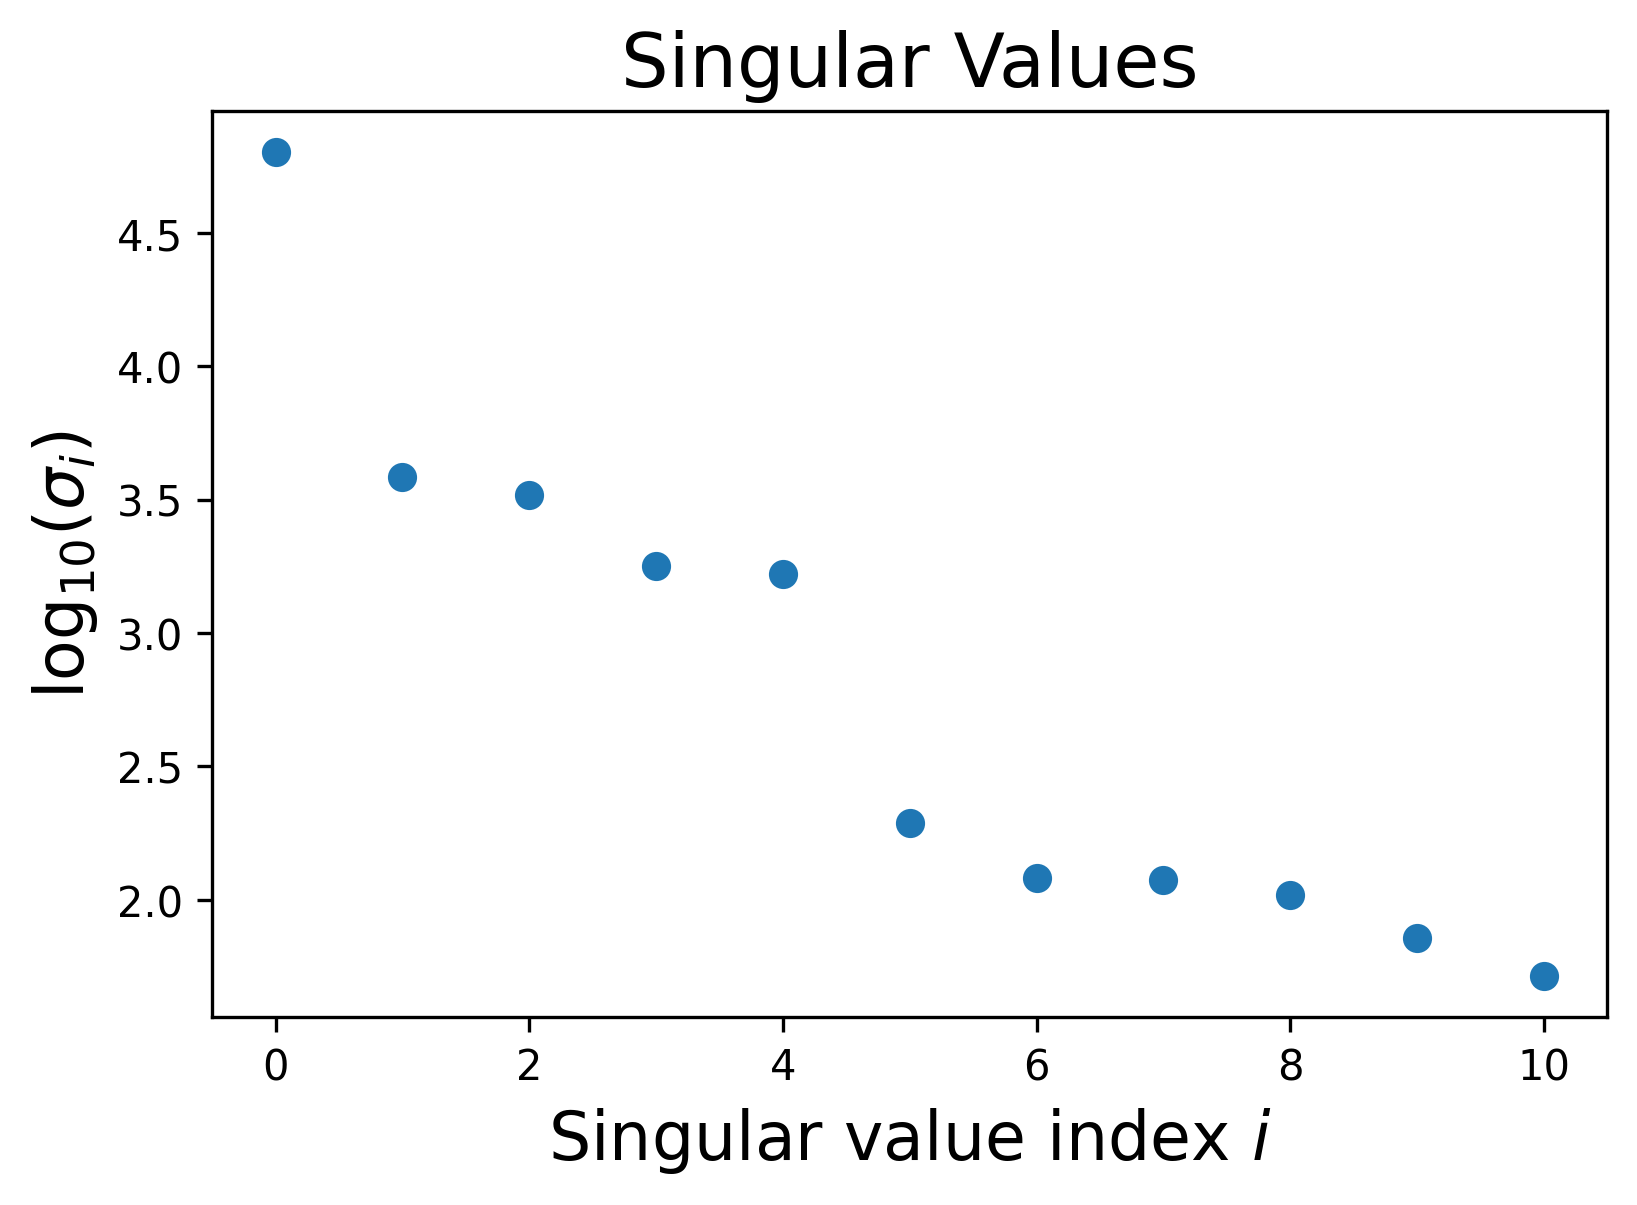

In [55]:
# singular values

U,s,VT = np.linalg.svd(A,full_matrices=False)
fig = plt.figure(figsize=(6,4), dpi= 300)
ax = fig.add_subplot(111)
ax.plot(np.log10(s),'o')
ax.set_xlabel('Singular value index $i$', fontsize=16)
ax.set_ylabel('$\log_{10}(\sigma_i)$', fontsize=16)
ax.set_title('Singular Values', fontsize=18)
plt.show()

In [33]:
# 10 subsets
rows, cols = A.shape
num_sets = 10
remainder = rows%num_sets
set_size = (rows-remainder)/num_sets
ind = []
for i in range(num_sets+1):
    if i <= num_sets - remainder:
        ind = np.append(ind,set_size*i)
    else:
        ind = np.append(ind,set_size + 1 + ind[-1])

In [47]:
num_class = 3
ERS = np.empty((num_sets,num_class))
ERR = np.empty((num_sets,num_class))
SQ_ER = np.empty((num_sets,num_class))
LAMBDA = np.empty((num_sets,num_class))

lam_vals = np.geomspace(1e-3,1e150,num=100) # logarithmically spaced values
lam_valsSVM = np.geomspace(1e-15,2,num=20)-1e-15

for i in range(num_sets):
    A_t, A_v, d_t, d_v = training_validation_sets(A,d,ind,i)
    A_t = np.hstack(( A_t, np.ones((A_t.shape[0],1)) ))
    A_v = np.hstack(( A_v, np.ones((A_v.shape[0],1)) ))

    # Best weights, and corresponding indices
    wR, indR = best_weights( Ridge(A_t,d_t,lam_vals),A_v,d_v ) # best Ridge regression weights among lam_vals
    wL, indL = best_weights( LASSO(A_t,d_t,lam_vals),A_v,d_v ) # best LASSO weights among lam_vals
    wS, indS = best_weights( SVM(A_t,d_t,lam_valsSVM),A_v,d_v ) # best SVM weights among lam_vals
    W_all = np.hstack((wR,wL,wS))

    # Error Metric
    ers, err, sq_er = error_metrics(W_all,A_v,d_v)
    ERS[i,:] = ers
    ERR[i,:] = err
    SQ_ER[i,:] = sq_er
    
    # Best Lambda Values
    LAMBDA[i,:] = [lam_vals[int(indR[0])], lam_vals[int(indL[0])], lam_valsSVM[int(indS[0])]]
    #LAMBDA[i,:] = [lam_vals[int(indR[0])], lam_vals[int(indL[0])], 0]

In [48]:
avg_ers = np.sum(ERS,axis=0)/num_sets
avg_err = np.sum(ERR,axis=0)/num_sets
avg_sqr = np.sum(SQ_ER,axis=0)/num_sets
lambdas  = np.sum(LAMBDA,axis=0)/num_sets

print('Average squared error:')
print('  Ridge: ',avg_sqr[0])
print('  LASSO: ',avg_sqr[1])
print('    SVM: ',avg_sqr[2])
print()

print('Average number of errors:')
print('  Ridge: ',avg_ers[0])
print('  LASSO: ',avg_ers[1])
print('    SVM: ',avg_ers[2])
print()

print('Average error rate:')
print('  Ridge: ',avg_err[0])
print('  LASSO: ',avg_err[1])
print('    SVM: ',avg_err[2])
print()

print('Best Average λ:')
print('  Ridge: ',lambdas[0])
print('  LASSO: ',lambdas[1])
print('    SVM: ',lambdas[2])

Average squared error:
  Ridge:  5322.107383365608
  LASSO:  6854.84026823334
    SVM:  6880.68355396275

Average number of errors:
  Ridge:  1886.1
  LASSO:  2269.0
    SVM:  3404.1

Average error rate:
  Ridge:  0.2742101526401558
  LASSO:  0.329878338568808
    SVM:  0.49490423948955903

Best Average λ:
  Ridge:  22.26022977513634
  LASSO:  1873817.4228603872
    SVM:  0.0
